In [1]:
# AWS
import boto3
import sagemaker

# data analysis
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('seaborn')
import seaborn as sns

In [5]:
# Sagemaker activation
session = boto3.session.Session()
region_name = session.region_name
print(f'region name: {region_name}')
sagemaker_session = sagemaker.Session()
bucket = 'klarnadataset'
role = sagemaker.get_execution_role()

region name: us-east-2


In [6]:
# load data from S3 bucket
data_key = 'dataset.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location,delimiter=';')
df.head(5)

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

# Exploration & Visualization

## 0) Target variable: 'default'

Defaulters percentage = 1.43%


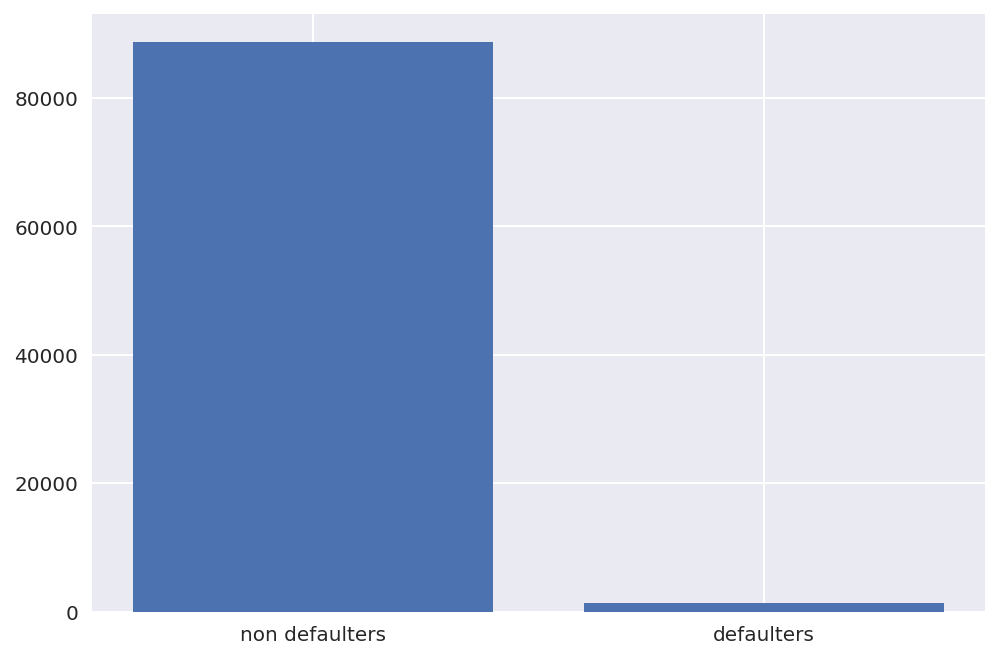

In [9]:
plt.bar(['non defaulters','defaulters'],
        df.groupby('default').count()['uuid'])
number_default = df.groupby('default').count()['uuid'][1]
number_no_default = df.groupby('default').count()['uuid'][0]
print(f'Defaulters percentage = {np.round((number_default / (number_default + number_no_default))*100,2)}%')

This class imbalance will be tackled later

## 1) General

Due to the class imbalance, practically no variable correlates to the target 'default' 


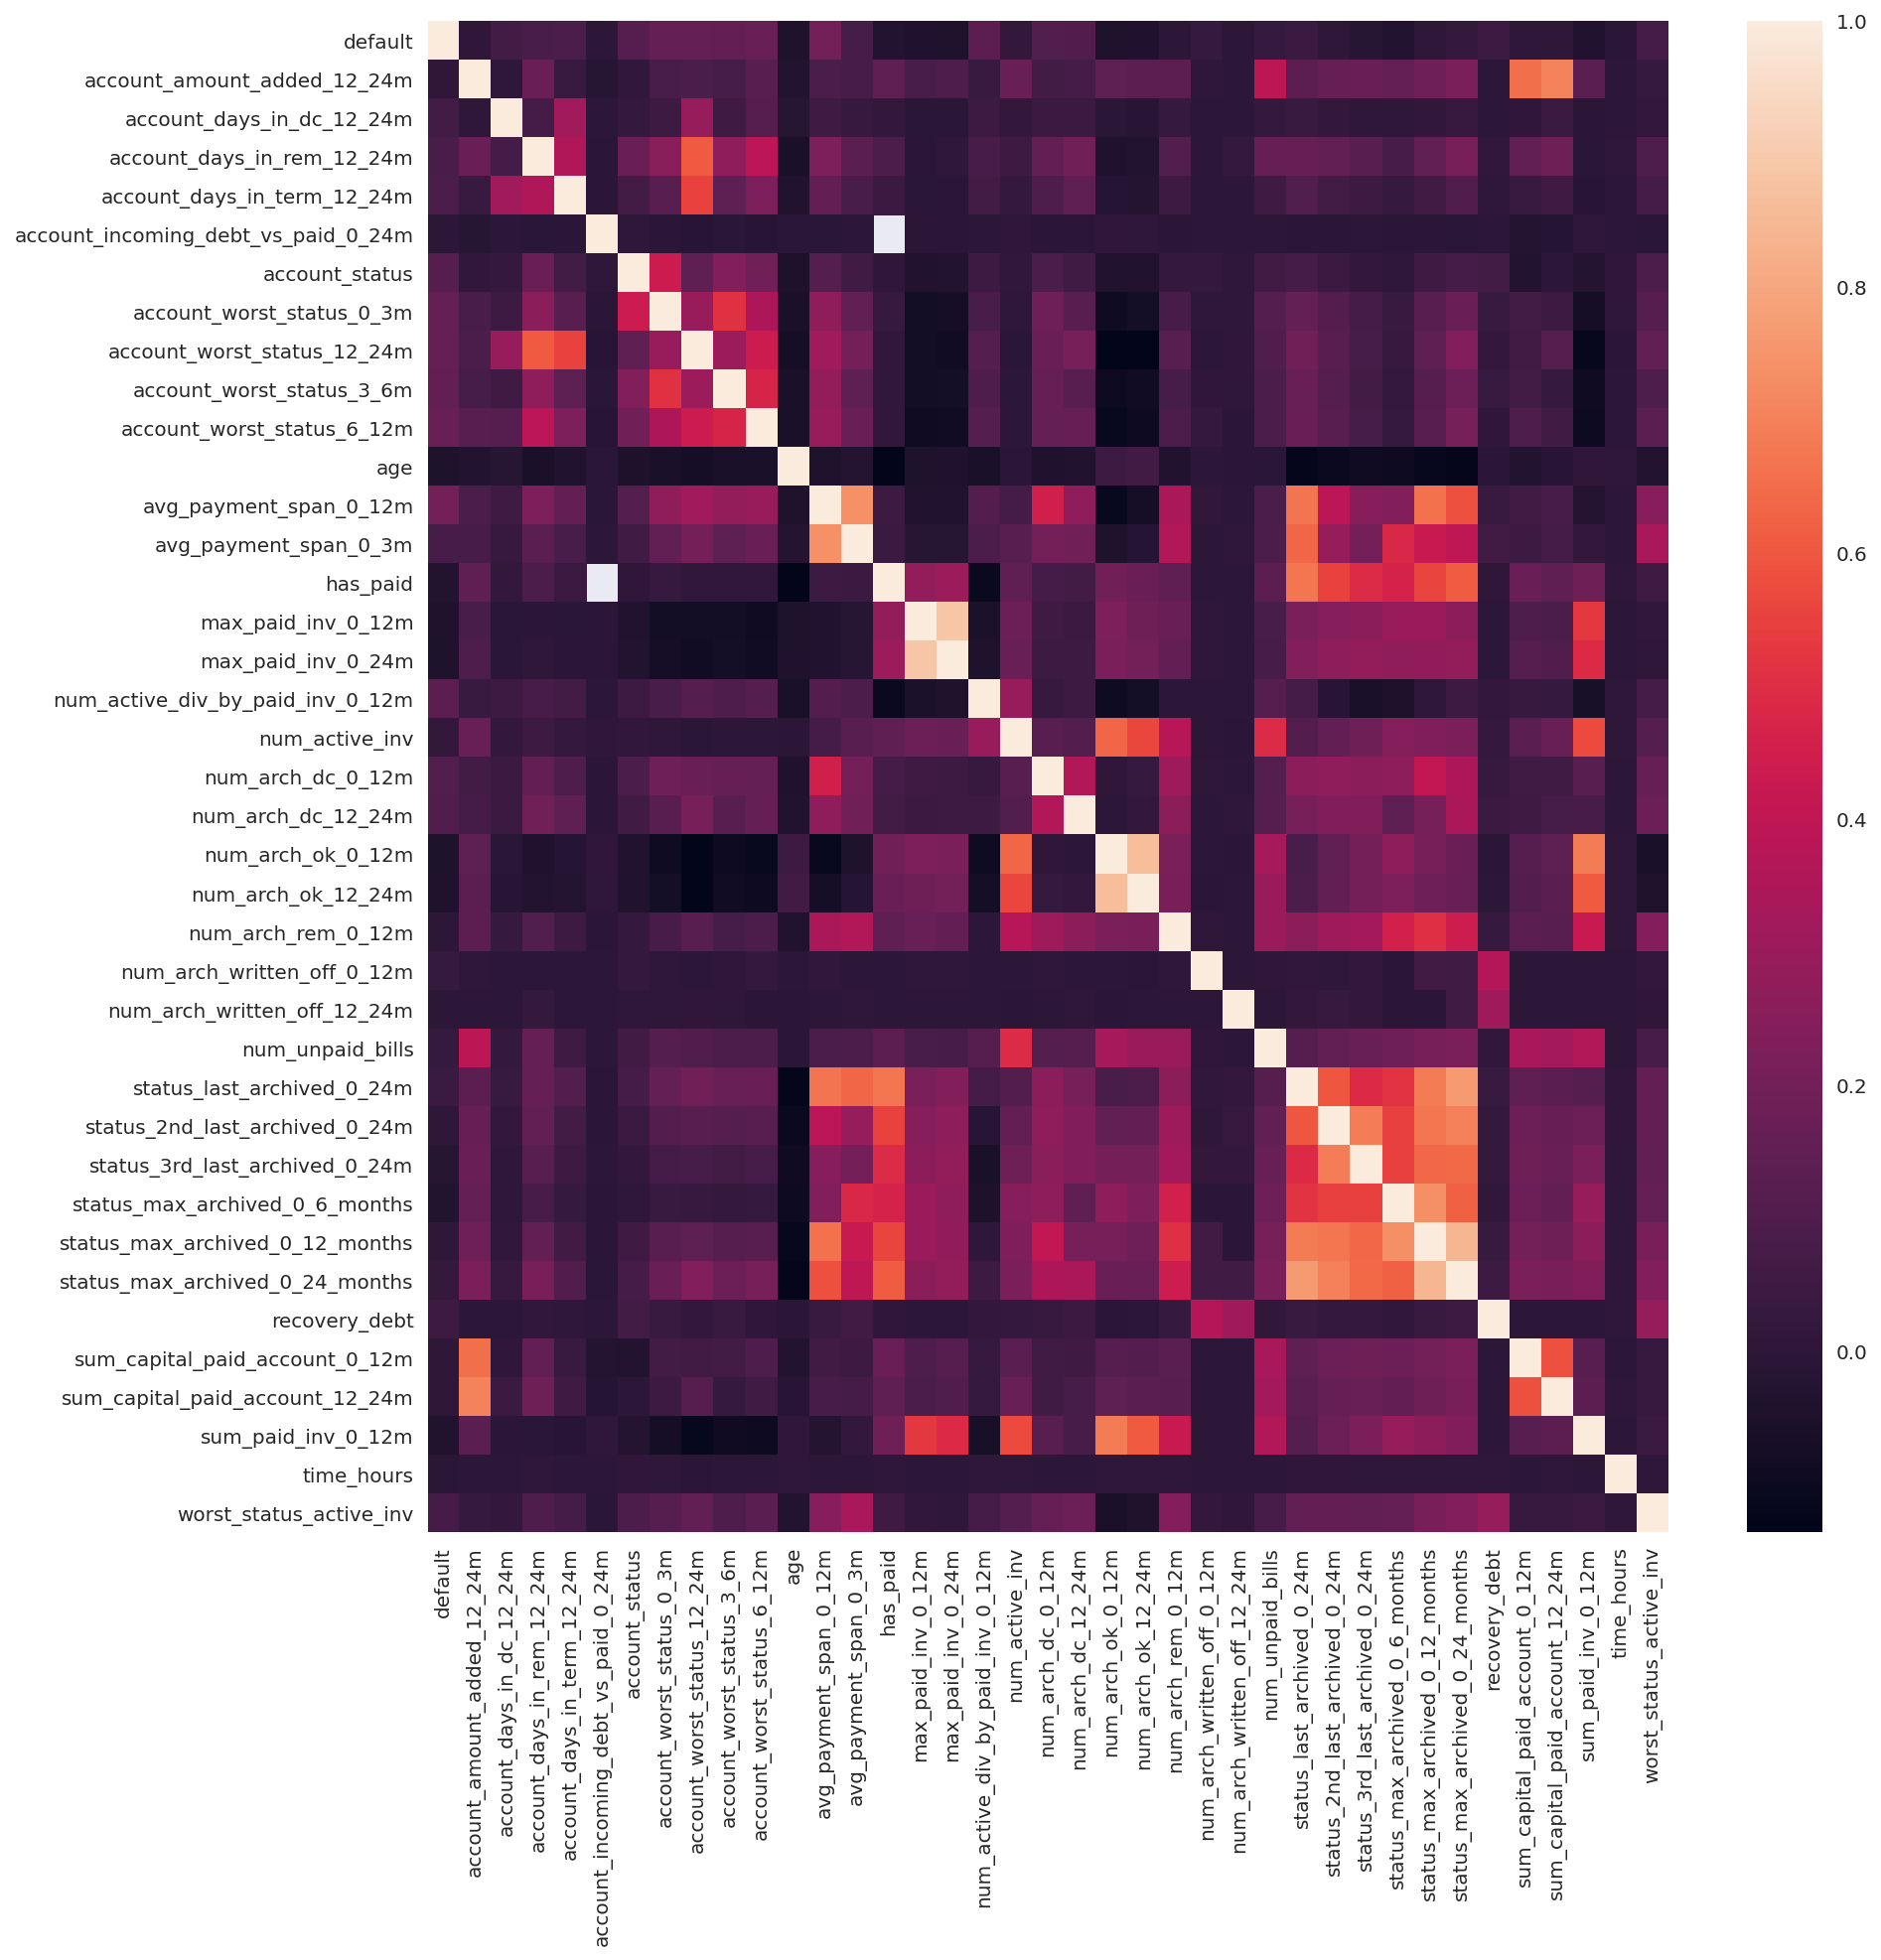

In [16]:
plt.figure(figsize=(14,14))
corr_matrix = sns.heatmap(df.corr())
print("Due to the class imbalance, practically no variable correlates to the target 'default' ")

number of defaulters = 1288.0
The 'account worst status' and the 'avg_payment_span' correlate positively with the target variable, while the 'has paid' column negatively, among others


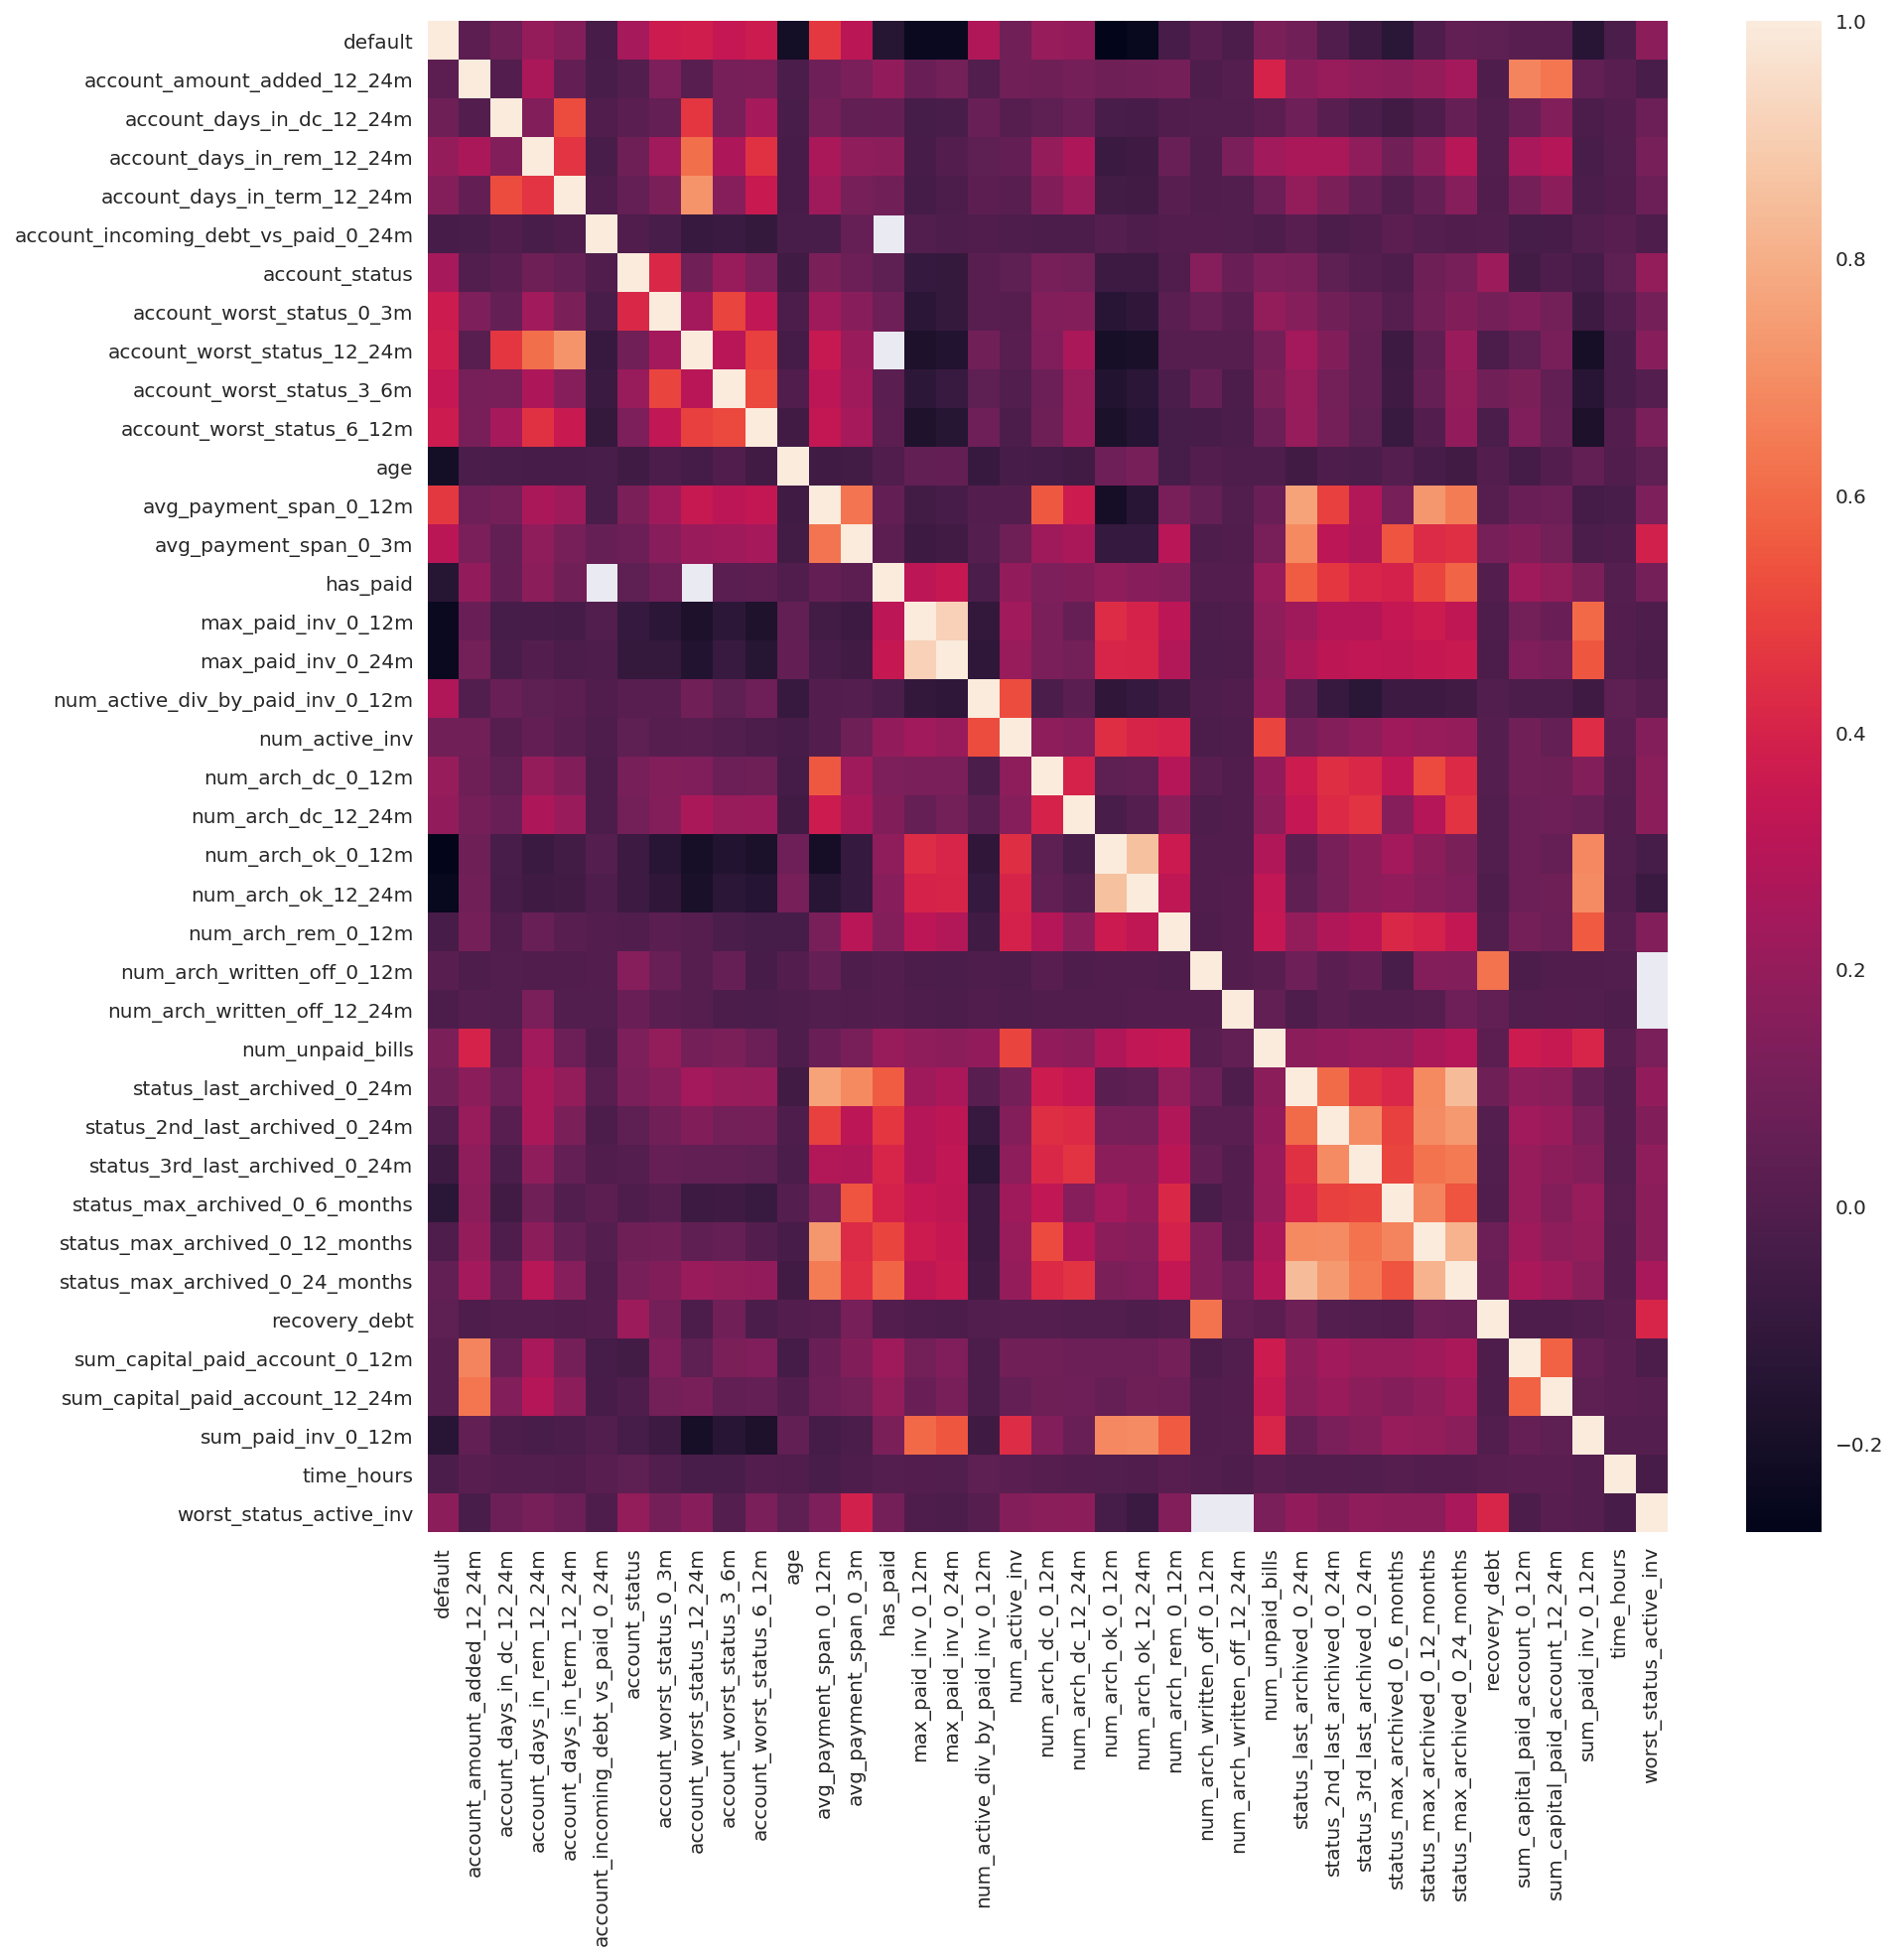

In [19]:
total_defaulters = df.groupby(by='default')['default'].sum()[1]
print(f'number of defaulters = {total_defaulters}') # number of defaulters

#small dataset with balanced class 1:1 defaulters
balanced_small_set = df.sort_values(by='default',ascending=False).iloc[:int(total_defaulters * 2)]
plt.figure(figsize=(14,14))
sns.heatmap(balanced_small_set.corr())
print("The 'account worst status' and the 'avg_payment_span' correlate positively with the target variable, while the 'has paid' column negatively, among others")

# Object-type features: merchant_category , merchant_group, name_in_email

### 2) name_in_email

In [20]:
df['name_in_email'].value_counts()

F+L         40389
no_match    16826
L1+F        16089
F            9705
Nick         8310
F1+L         7300
L            1332
Initials       25
Name: name_in_email, dtype: int64

#### Whether customers provide their personal infromation in their email address might provide insights in their credibility 

In [22]:
def email_address_format(x):
    if x in ['no_match','Nick']: # doesn't reveal personal information
        x = 0                 
    elif x in ['F+L','L1+F','F','F1+L','L','Initials']:  # provides personal information
        x = 1                 
    else:
        pass
    return x

In [23]:
df['name_in_email'] = df['name_in_email'].apply(lambda x: email_address_format(x))
df['name_in_email'].head(5)

0    0
1    1
2    1
3    1
4    1
Name: name_in_email, dtype: int64

Text(0, 0.5, 'defaulters (%)')

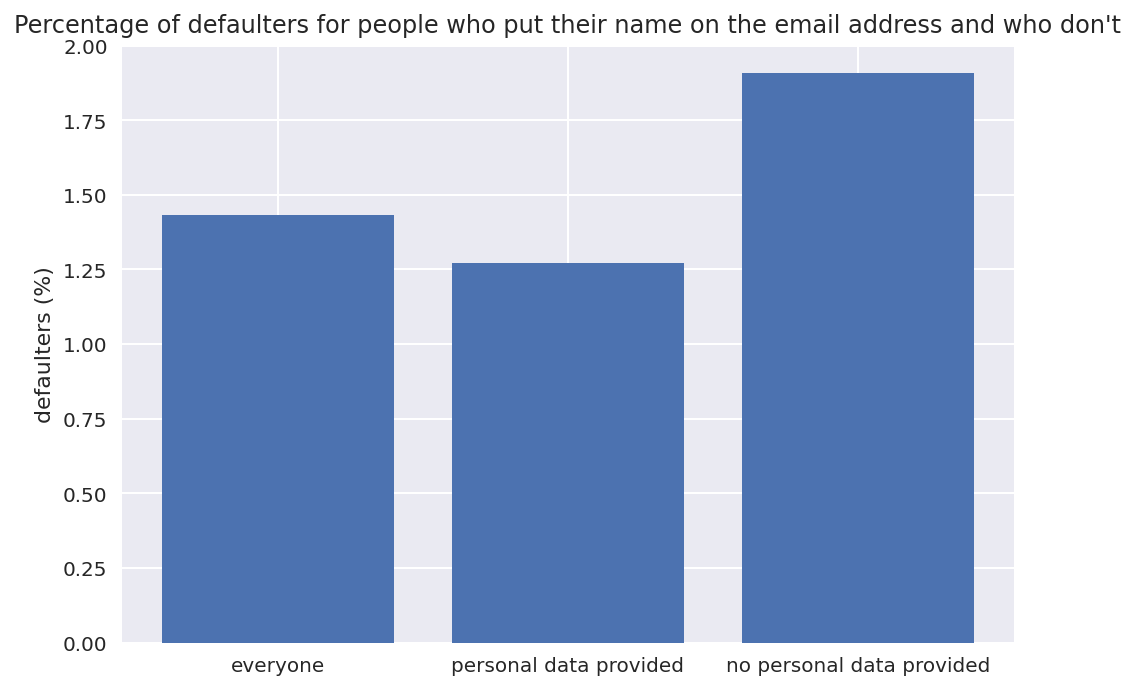

In [35]:
# Percentage of default for people who put their name on the email address and who don't
no_info_provided = (df[df['name_in_email']==0.]['default'].value_counts()[1]  / df[df['name_in_email']==0.]['default'].count()) * 100
info_provided = (df[df['name_in_email']==1.]['default'].value_counts()[1]  / df[df['name_in_email']==1.]['default'].count()) * 100
everyone = (df['default'].value_counts()[1]  / df['default'].count()) * 100 


plt.title("Percentage of defaulters for people who put their name on the email address and who don't")
plt.bar(['everyone','personal data provided','no personal data provided'],[everyone,info_provided,no_info_provided] )
plt.ylabel('defaulters (%)')

#### Qualitatively, the likelihood of default increases for people who don't share their name on the email address

### 3) merchant_group

In [36]:
df['merchant_group'].value_counts()

Entertainment             48779
Clothing & Shoes          16728
Leisure, Sport & Hobby    11025
Health & Beauty            7356
Children Products          5108
Home & Garden              3718
Electronics                3034
Intangible products        1122
Jewelry & Accessories      1058
Automotive Products         937
Erotic Materials            747
Food & Beverage             364
Name: merchant_group, dtype: int64

In [30]:
percent_default = pd.DataFrame((df.groupby('merchant_group').sum()['default'] / 
                                df.groupby('merchant_group').count()['default']) * 100).rename(columns={'default':'defaulters (%)'})
percent_default['number_customers'] = df.groupby('merchant_group').count()['default']
percent_default.sort_values(by='number_customers',inplace=True)
percent_default

,defaulters (%),number_customers
merchant_group,,
Food & Beverage,9.090909,330
Erotic Materials,3.880597,670
Automotive Products,2.004717,848
Jewelry & Accessories,1.797040,946
Intangible products,6.391347,1017
Electronics,2.329882,2704
Home & Garden,1.850746,3350
Children Products,1.257044,4614
Health & Beauty,1.578388,6589


The merchant group has an impact on the default ratio.


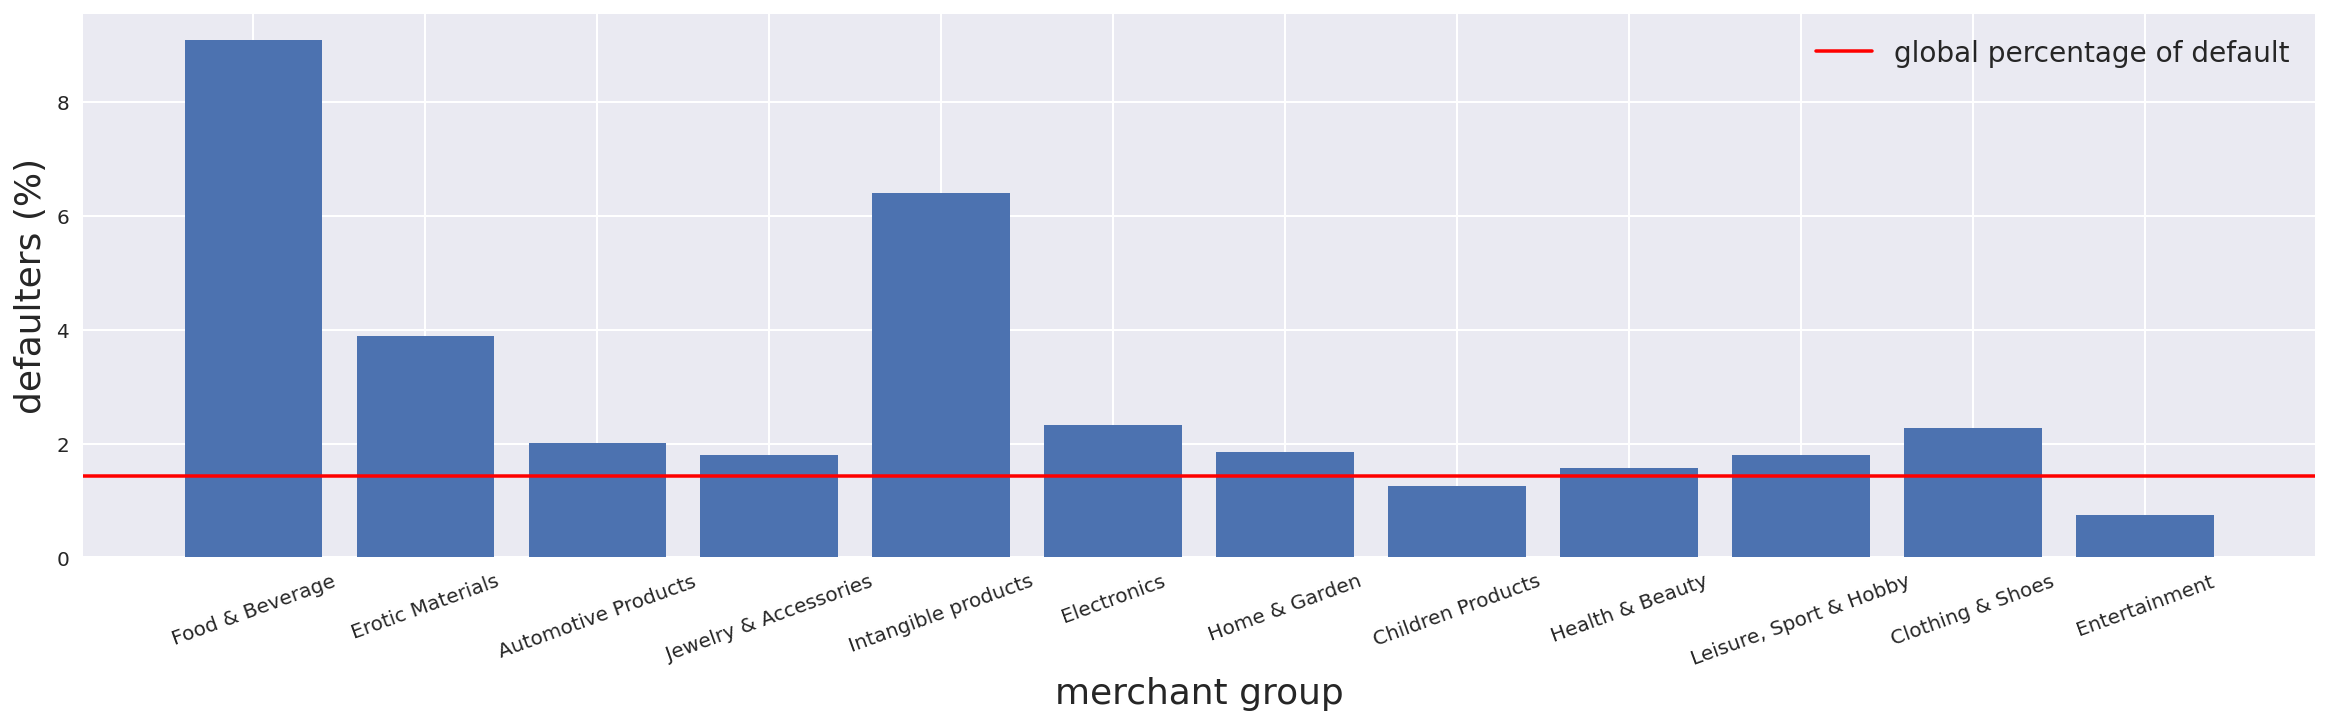

In [33]:
total_percent_default = (df['default'].sum() / df['default'].count())*100

plt.figure(figsize=(20,5))
plt.bar(percent_default.index,percent_default['defaulters (%)'])
plt.axhline(y=total_percent_default, color='r', linestyle='-',label = 'global percentage of default')
plt.xticks(rotation = 20)
plt.ylabel('defaulters (%)',fontsize=18)
plt.xlabel('merchant group',fontsize=18)
plt.legend(fontsize=14)
print('The merchant group has an impact on the default ratio.')

#### There is impact of the merchant group on the proportion of defaulters

### 4) merchant_category

In [44]:
df['merchant_category'].value_counts()
print(f"number of categories: {df['merchant_category'].nunique()}")

number of categories: 57


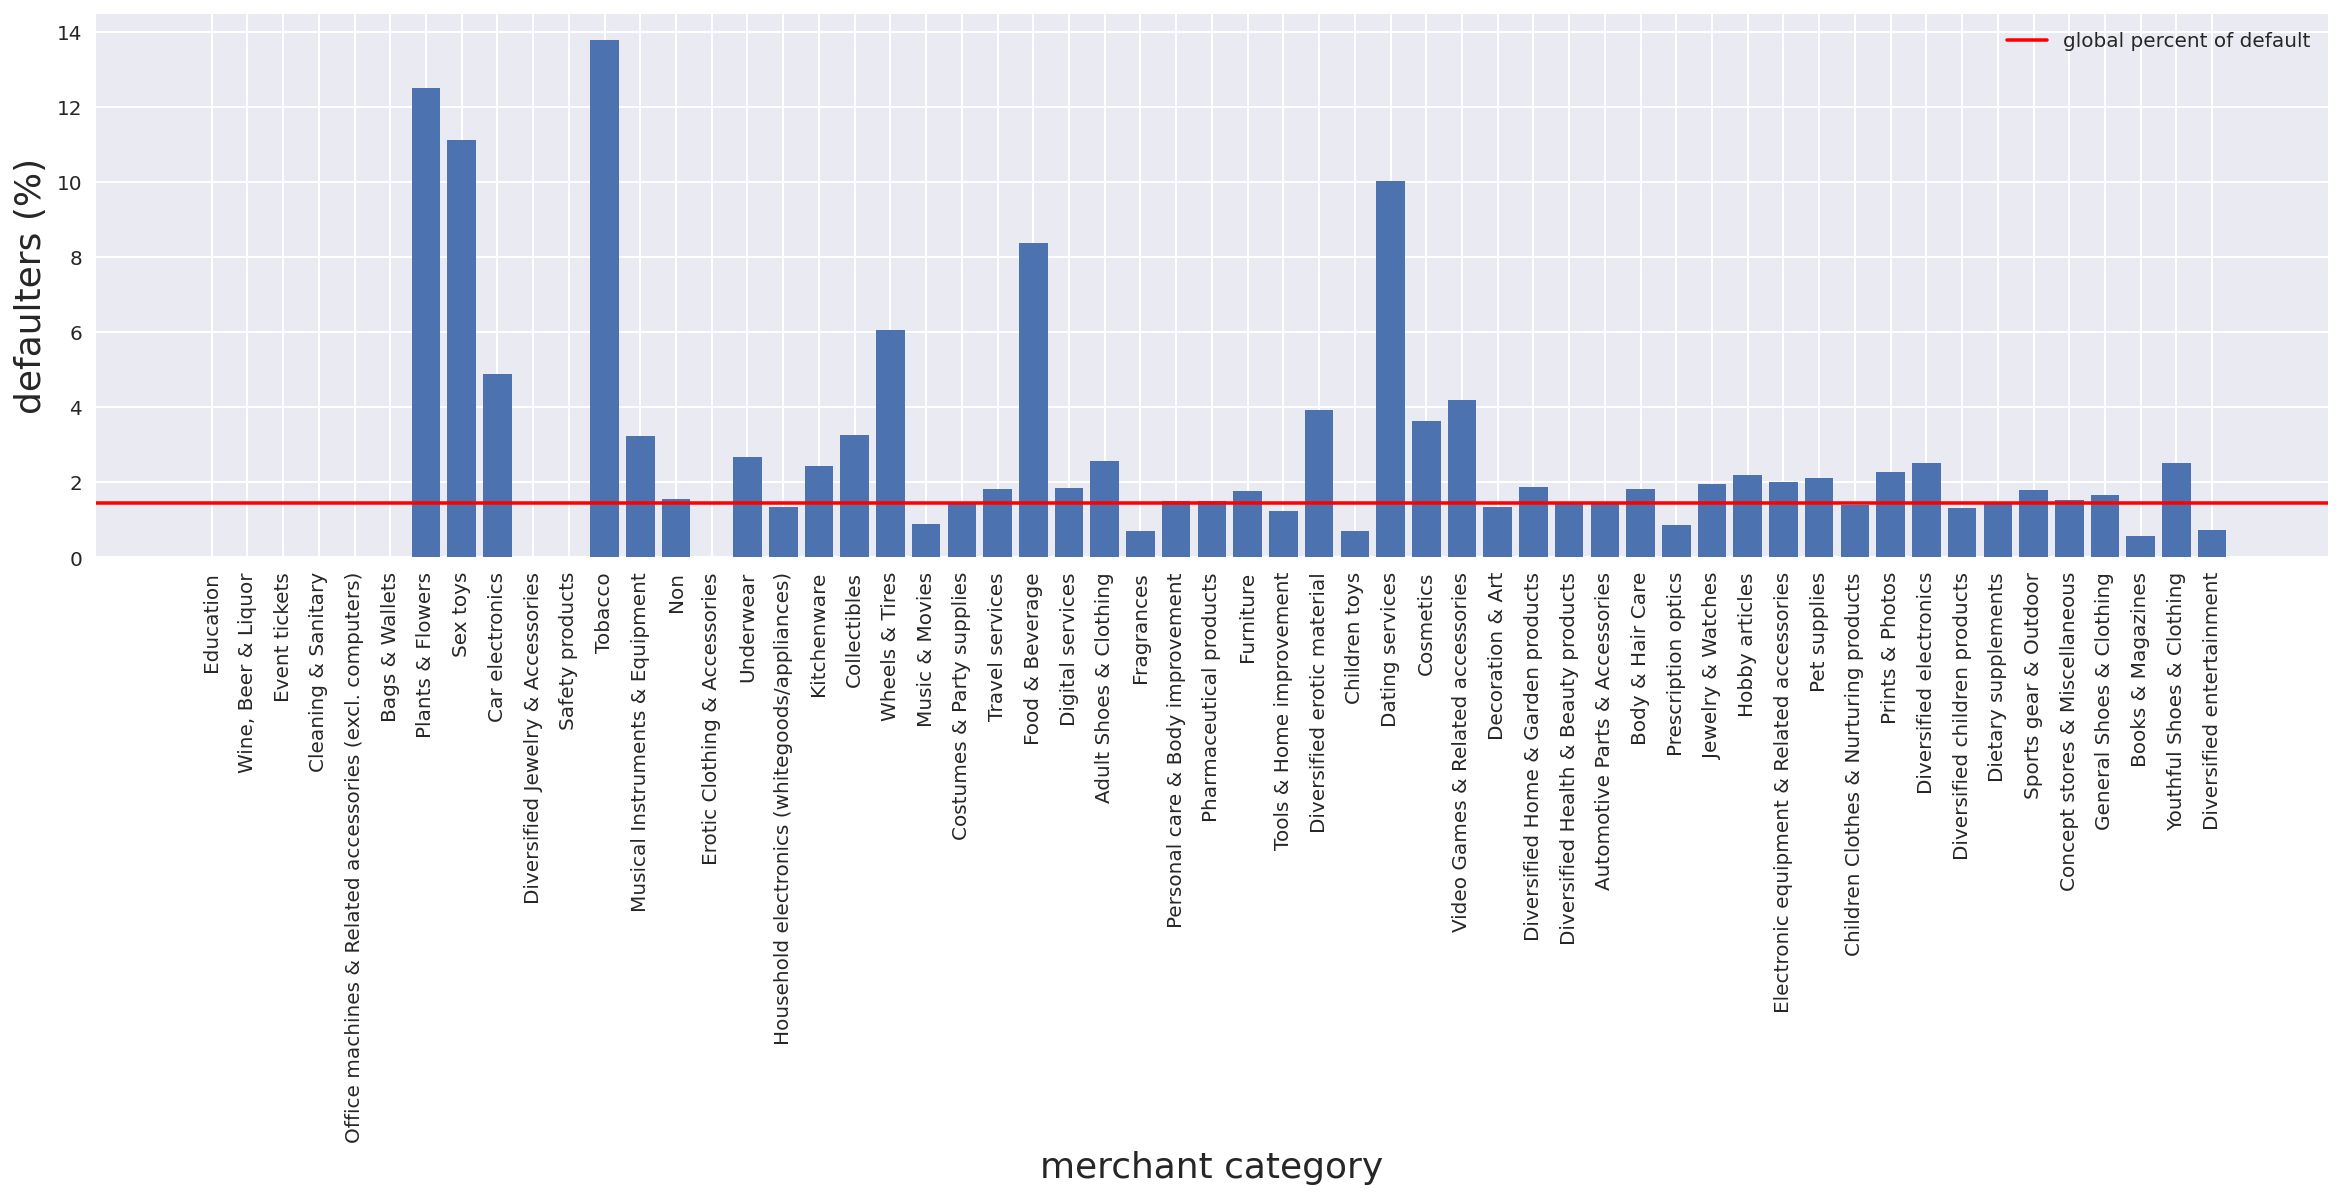

In [38]:
plt.figure(figsize=(20,5))
total_percent_default = (df['default'].sum() / df['default'].count())*100

percent_default = pd.DataFrame((df.groupby('merchant_category').sum()['default'] / 
                                df.groupby('merchant_category').count()['default']) * 100).rename(columns={'default':'percent_default'})
percent_default['number_customers'] = df.groupby('merchant_category').count()['default']
percent_default.sort_values(by='number_customers',inplace=True)
plt.bar(percent_default.index,percent_default['percent_default'])
plt.axhline(y=total_percent_default, color='r', linestyle='-',label = 'global percent of default')
plt.xticks(rotation = 90)
plt.ylabel('defaulters (%)',fontsize=18)
plt.xlabel('merchant category',fontsize=18)
plt.legend()

#### Although there is an influence on the defaulters proportion, this category will be dropped, since it is a subclass of the group_merchant. Its incorporation would imply 57 new columns of dummy variables, that might affect negatively the model performance.

## 5) has_paid

Defaulters tend to having paid less than no defaulters


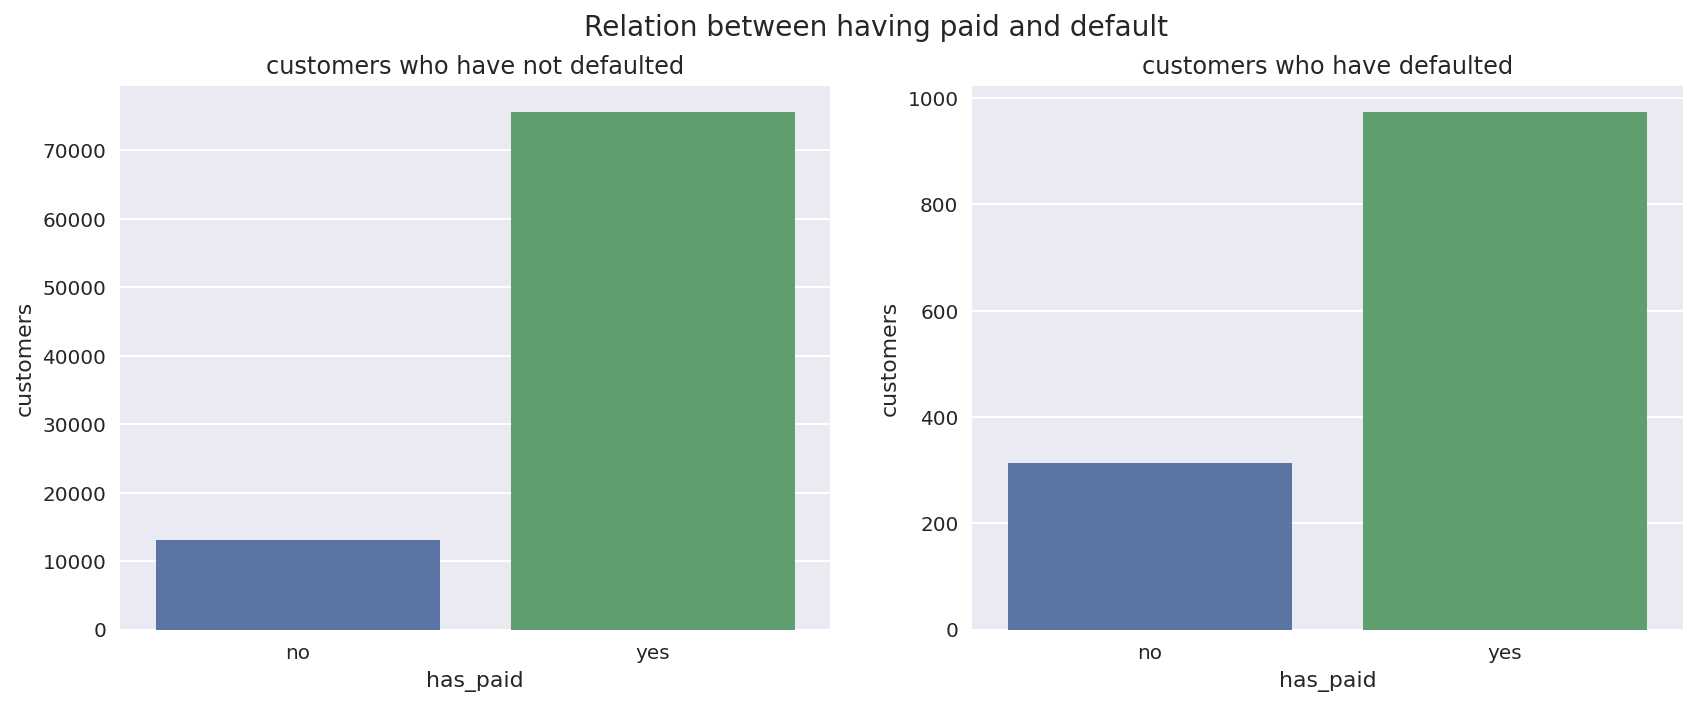

In [45]:
fig,axs = plt.subplots(1,2,figsize=(14,5))
fig.suptitle('Relation between having paid and default',fontsize=14)

sns.countplot(x ='has_paid',data=df[df['default']==0.],ax=axs[0])
axs[0].set_title('customers who have not defaulted')
axs[0].set_xticklabels(['no','yes'])
axs[0].set_ylabel('customers')

sns.countplot(x ='has_paid',data=df[df['default']==1.],ax=axs[1])
axs[1].set_title('customers who have defaulted')
axs[1].set_xticklabels(['no','yes'])
axs[1].set_ylabel('customers')

print('Defaulters tend to having paid less than no defaulters')

In [48]:
pd.crosstab(index = df['has_paid'], 
            columns = df['default'] ,dropna=True,margins=True,normalize='index') * 100

default,0.0,1.0
has_paid,,
False,97.657765,2.342235
True,98.727961,1.272039
All,98.568507,1.431493


#### As seen in the correlation matrix in (1), defaulters have paid less than non defaulters

## 6) Age

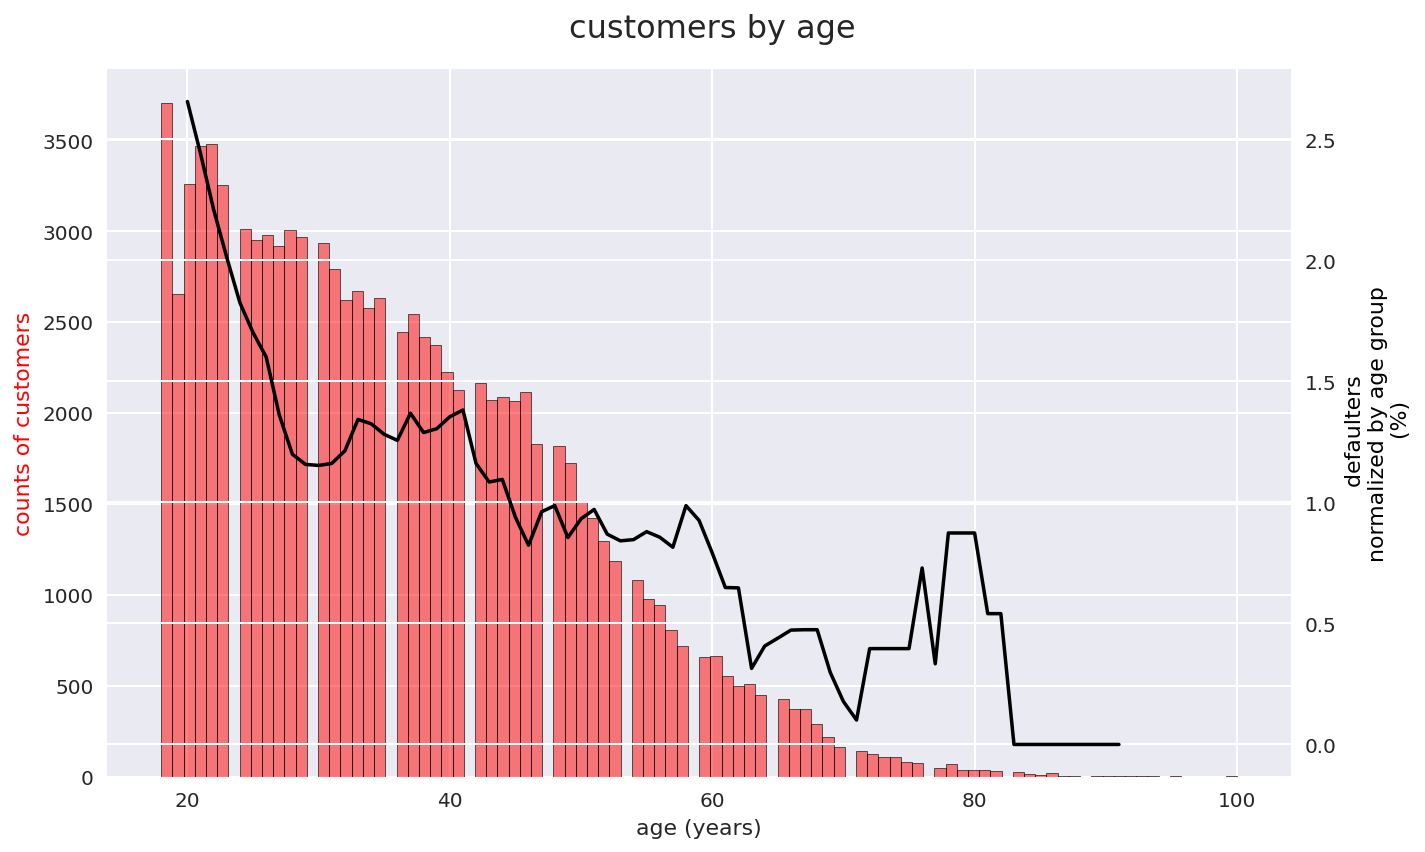

In [56]:
fig, ax1 = plt.subplots(figsize=(10,6))
fig.suptitle('customers by age',fontsize='16')
ax2 = ax1.twinx()


ax1.set_xlabel('age (years)')
ax1.set_ylabel('counts of customers', color='red')
ax2.set_ylabel('defaulters  \n normalized by age group \n (%)', color='black')

sns.histplot(df['age'],kde=False,alpha=0.5,label='everyone',ax=ax1,color='red')

ax2.plot(((df.groupby(by='age').sum()['default'] / df.groupby(by='age').count()['default'])* 100).rolling(5,center=True).mean(),color='black')

fig.tight_layout()

#### The trend shows higher chances of default on young people. Specially in the low 20s, the most active age group.

## 7) Account Status

In [57]:
number_account_status = df['account_status'].dropna().value_counts()
percent_account_status = (df['account_status'].dropna().value_counts() / df['account_status'].dropna().count()) * 100
account_status_merge = pd.concat([number_account_status,percent_account_status],axis=1)
account_status_merge.columns = ['account_status','account_status_percent']
account_status_merge

,account_status,account_status_percent
1.0,43693,95.811679
2.0,1900,4.166393
3.0,7,0.015350
4.0,3,0.006579


In [58]:
account_status_default_no_nan = df.loc[df.loc[df['account_status'].dropna().index]['default'].dropna().index]

pd.crosstab(index = account_status_default_no_nan['default'], 
            columns = account_status_default_no_nan['account_status'] ,dropna=True,margins=True,normalize='index') * 100

19% of defaulters have an account status = 2, while for non defualters only 4 %


account_status,1.0,2.0,3.0,4.0
default,,,,
0.0,96.197085,3.790479,0.012436,0.000000
1.0,79.904306,19.497608,0.239234,0.358852
All,95.865211,4.110423,0.017056,0.007310


#### 19% of defaulters have an account status = 2, while for non defualters only 4 %

In [62]:
# 'account status' linear correlation with other variables
df.loc[df['account_status'].dropna().index].corr()['account_status'].sort_values(ascending=False).head(6)

account_status                 1.000000
account_worst_status_0_3m      0.434235
account_worst_status_3_6m      0.237206
account_worst_status_6_12m     0.189594
account_days_in_rem_12_24m     0.170864
account_worst_status_12_24m    0.147503
Name: account_status, dtype: float64

## 8) Worst status

In [70]:
# New feature of the worst historical account status 
worst_status = pd.DataFrame(df[['account_status','account_worst_status_0_3m',
                                'account_worst_status_12_24m',
                                'account_worst_status_3_6m',
                                'account_worst_status_6_12m']].max(axis=1)).rename(columns = {0:'status'})
status_default = pd.DataFrame()
for status in range(1,5):
    worst_status_mask = worst_status[worst_status['status'] == status].index    # indexes with a certain account status 
    status_default[status] = df.loc[worst_status_mask]['default'].value_counts()
status_default = status_default.transpose()
status_default.columns = ['no default','default']
status_default.index.name = 'worst status'
# probability of default with for each worst historical status
status_default['prob_default'] = (status_default['default'] / (status_default['default'] + status_default['no default']))

In [71]:
status_default

,no default,default,prob_default
worst status,,,
1,25509,229,0.008897
2,12680,338,0.025964
3,1651,166,0.091359
4,366,103,0.219616


The probability of default increases with the historical worst account status


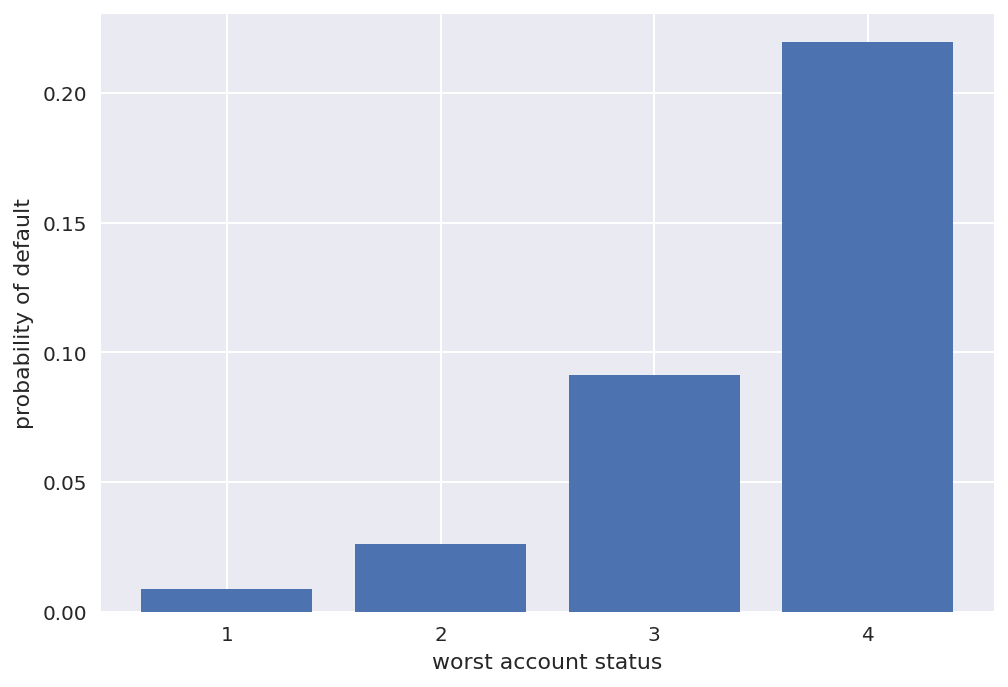

In [72]:
plt.bar(status_default.index,status_default['prob_default'])
plt.xticks([1,2,3,4])
plt.ylabel('probability of default')
plt.xlabel('worst account status')
print('The probability of default increases with the historical worst account status')

## 9) worst_status_active_inv (69 k missing values)

In [73]:
df['worst_status_active_inv'].dropna().value_counts()

1.0    26922
2.0     3369
3.0      170
Name: worst_status_active_inv, dtype: int64

In [74]:
print('Defaulters tend to have higher worst account status')
pd.crosstab(index = df['default'], 
            columns = df['worst_status_active_inv'] ,normalize='index',dropna=True,margins=True)

Defaulters tend to have higher worst account status


worst_status_active_inv,1.0,2.0,3.0
default,,,
0.0,0.886103,0.108734,0.005164
1.0,0.729207,0.239845,0.030948
All,0.883146,0.111204,0.005650


In [76]:
print('Interestingly, it doest correlate strongly with the account_worst_status variables. But it does with some other columns')
df.loc[df['worst_status_active_inv'].dropna().index].corr()['worst_status_active_inv'].sort_values(ascending=False)

Interestingly, it doest correlate strongly with the account_worst_status variables. But it does with some other columns


worst_status_active_inv                1.000000
avg_payment_span_0_3m                  0.336804
recovery_debt                          0.291179
avg_payment_span_0_12m                 0.250440
num_arch_rem_0_12m                     0.241682
status_max_archived_0_24_months        0.237386
status_max_archived_0_12_months        0.213368
num_arch_dc_12_24m                     0.178773
num_arch_dc_0_12m                      0.161202
status_max_archived_0_6_months         0.158152
status_last_archived_0_24m             0.155782
status_2nd_last_archived_0_24m         0.154172
status_3rd_last_archived_0_24m         0.149774
account_worst_status_12_24m            0.147791
account_worst_status_6_12m             0.132446
account_worst_status_0_3m              0.119861
num_active_inv                         0.114733
account_worst_status_3_6m              0.098820
account_days_in_rem_12_24m             0.098200
account_status                         0.092821
num_unpaid_bills                       0

<AxesSubplot:xlabel='worst_status_active_inv', ylabel='recovery_debt'>

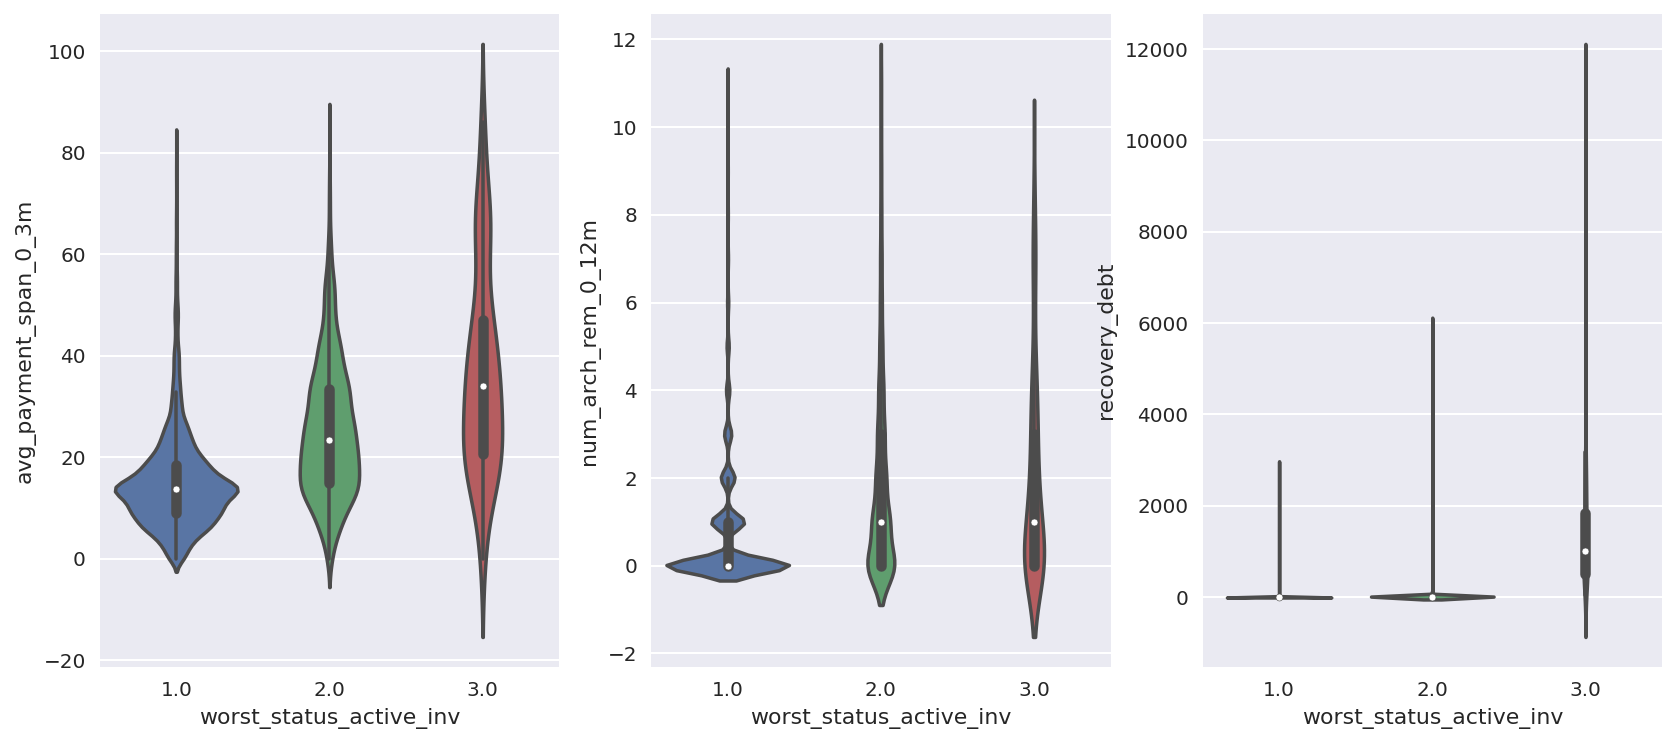

In [77]:
fig,ax = plt.subplots(1,3,figsize=(14,6))
sns.violinplot(y='avg_payment_span_0_3m',
               x='worst_status_active_inv',
               data=df,
               ax=ax[0])

sns.violinplot(y='num_arch_rem_0_12m',
               x='worst_status_active_inv',
               data=df[df['num_arch_rem_0_12m'] < 12],
               ax=ax[1])

sns.violinplot(y='recovery_debt',
               x='worst_status_active_inv',
               data=df[df['num_arch_rem_0_12m'] < 12],
               ax=ax[2])

#### In notebook (1), these correlations are used to fill the nan

## 10) avg_payment_span_0_12m & avg_payment_span_0_3m

In [78]:
df.loc[df['avg_payment_span_0_3m'].dropna().index].corr()['avg_payment_span_0_3m'].sort_values(ascending=False).head(8)

avg_payment_span_0_3m              1.000000
avg_payment_span_0_12m             0.741739
status_last_archived_0_24m         0.635273
status_max_archived_0_6_months     0.484902
status_max_archived_0_12_months    0.427340
status_max_archived_0_24_months    0.398045
num_arch_rem_0_12m                 0.364076
worst_status_active_inv            0.336804
Name: avg_payment_span_0_3m, dtype: float64

<AxesSubplot:xlabel='status_max_archived_0_24_months', ylabel='avg_payment_span_0_12m'>

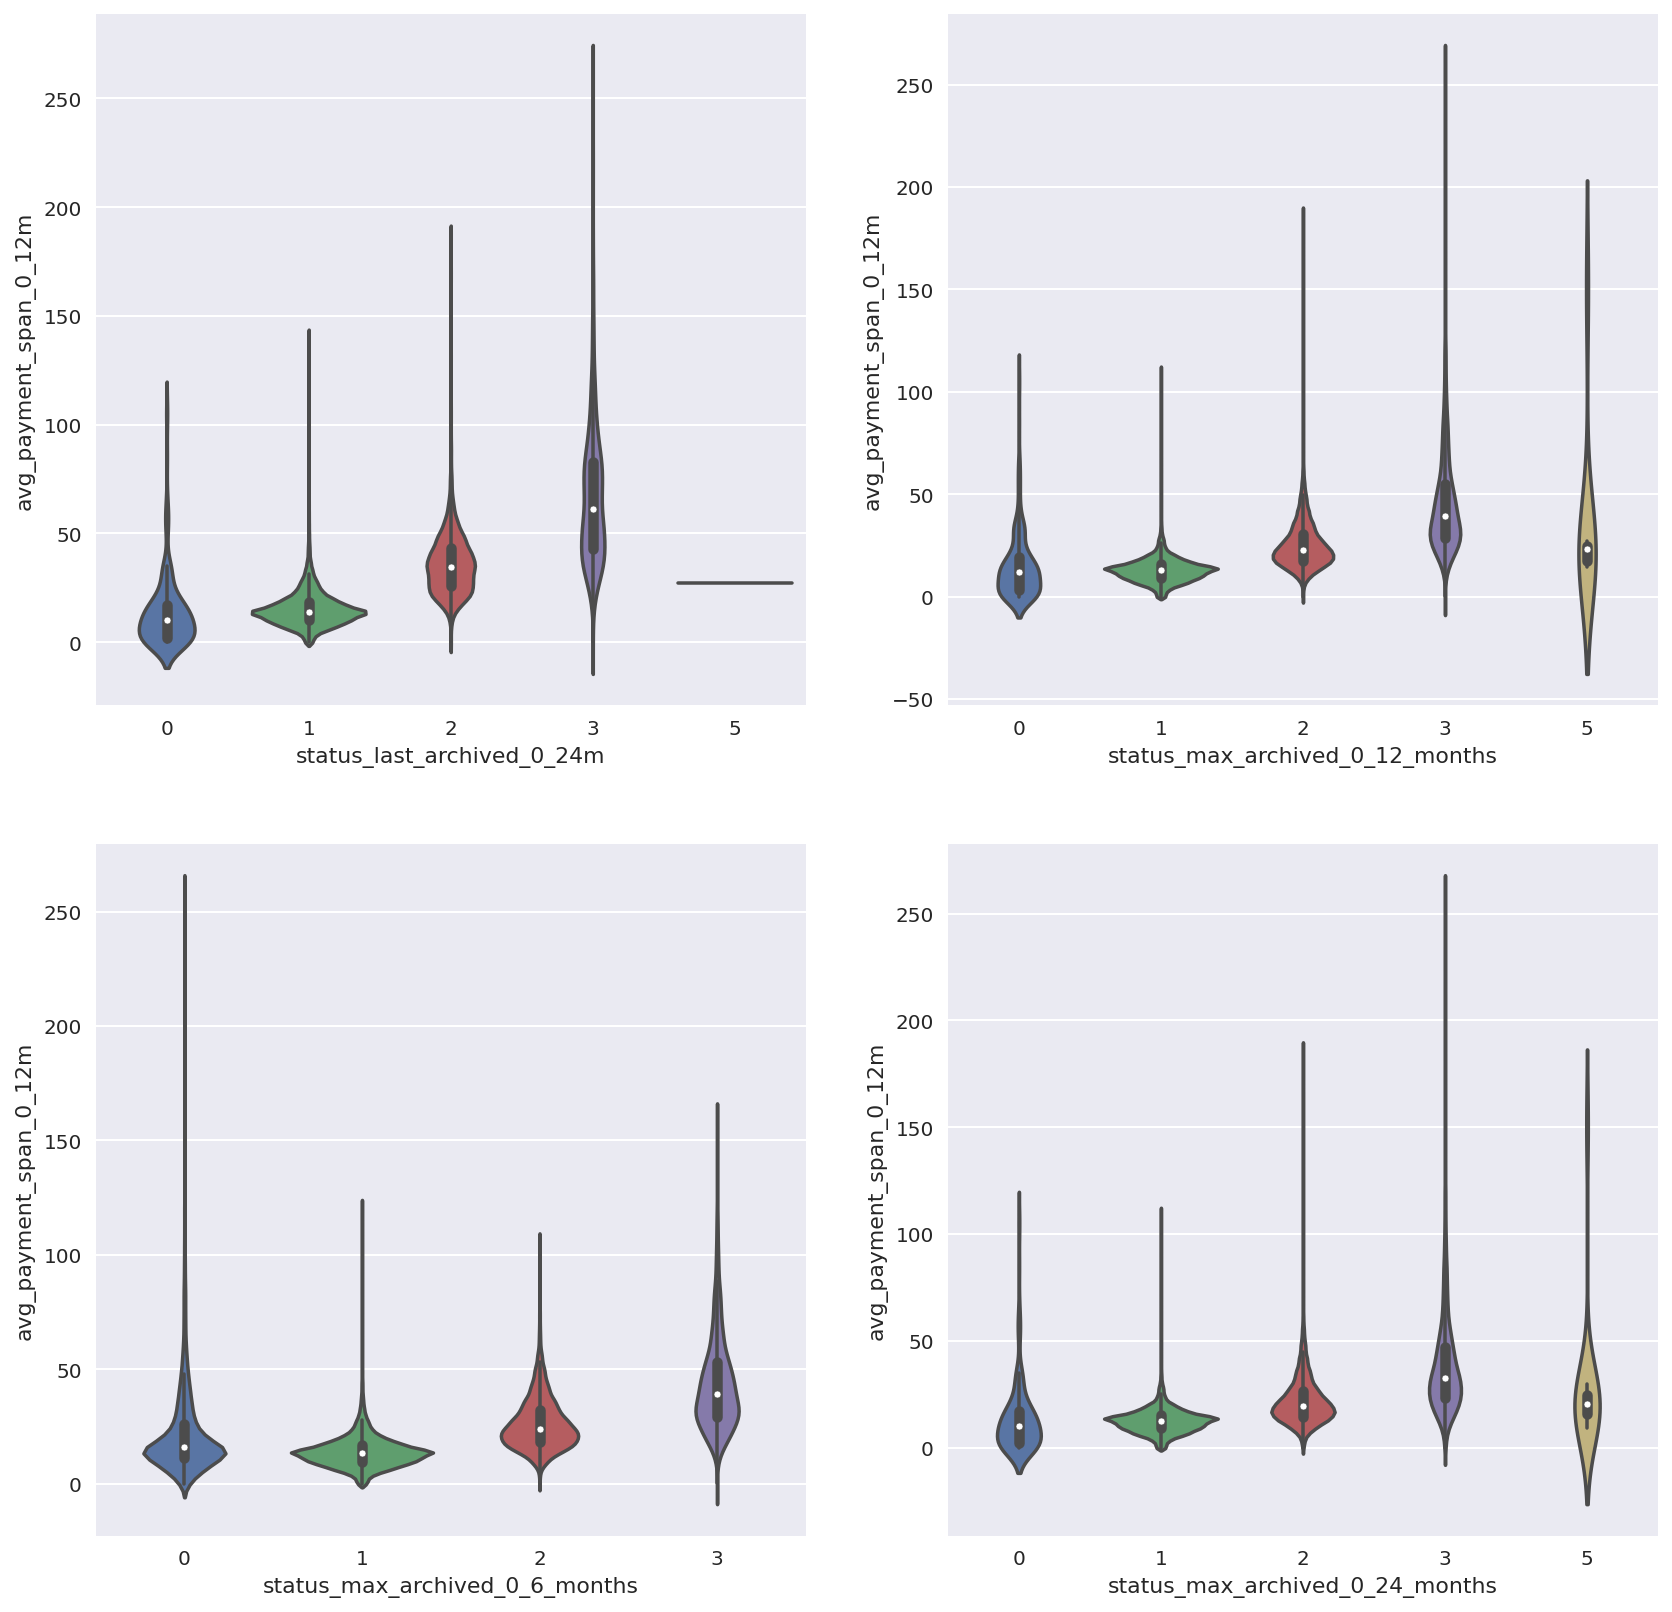

In [79]:
fig,ax = plt.subplots(2,2,figsize=(14,14))
sns.violinplot(y='avg_payment_span_0_12m',x='status_last_archived_0_24m',data=df,ax=ax[0][0])
sns.violinplot(y='avg_payment_span_0_12m',x='status_max_archived_0_6_months',data=df,ax=ax[1][0])
sns.violinplot(y='avg_payment_span_0_12m',x='status_max_archived_0_12_months',data=df,ax=ax[0][1])
sns.violinplot(y='avg_payment_span_0_12m',x='status_max_archived_0_24_months',data=df,ax=ax[1][1])

#### In notebook (1), these variables are used to fit a linear model to fill the nan

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='avg_payment_span_0_12m', ylabel='avg_payment_span_0_3m'>

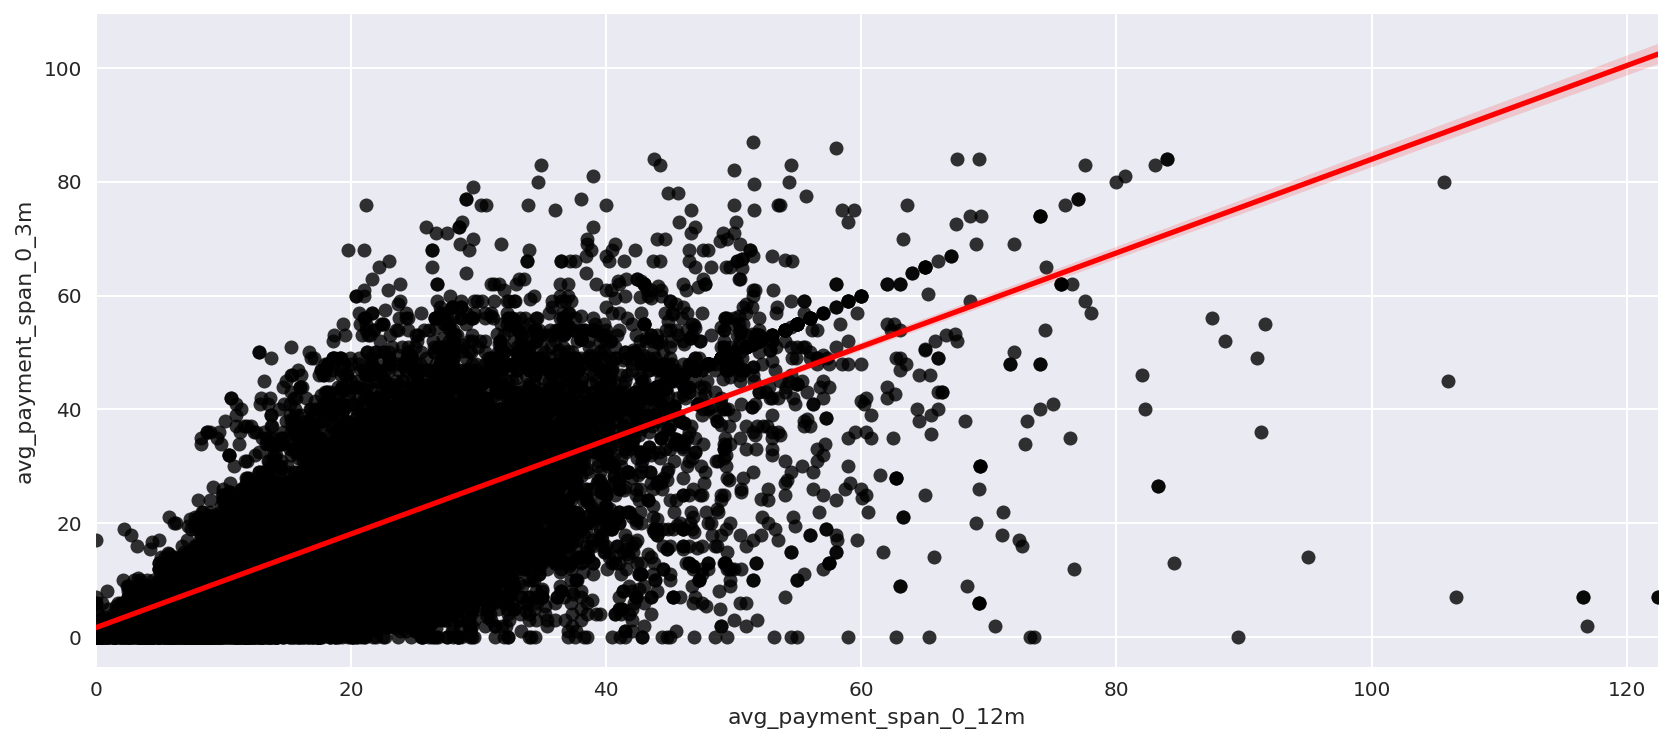

In [80]:
avg_payment_no_nan = df[['avg_payment_span_0_12m','avg_payment_span_0_3m']].dropna()
plt.figure(figsize=(14,6))
sns.regplot('avg_payment_span_0_12m','avg_payment_span_0_3m',avg_payment_no_nan,scatter_kws={"color": "black"}, line_kws={"color": "red"})

#### Both variables 'avg_payment_span_0_12m' & 'avg_payment_span_0_3m' follow a linear trend that it is also used to fill the nan

## 11) num_arch_written_off_0_12m & num_arch_written_off_12_24m

In [81]:
df['num_arch_written_off_12_24m'].value_counts()

0.0    81887
1.0        9
2.0        2
Name: num_arch_written_off_12_24m, dtype: int64

In [82]:
df['num_arch_written_off_0_12m'].value_counts()

0.0    81888
1.0       10
Name: num_arch_written_off_0_12m, dtype: int64

#### These 2 columns are practically zero-columns. They will be dropped off.

## 12) account_days_in_rem_12_24m

In [83]:
# function that plots histograms a certain variable for defaulters and non defaulters

def defaulter_vs_non_defaulters(feature):
    fig,ax = plt.subplots(1,2,figsize=(14,5))
    fig.suptitle(feature,fontsize='16')
    a1 = ax[0].hist(df[df['default'] == 0.][feature].dropna())
    ax[0].set_title('non defaulters')
    ax[0].set_ylabel('counts')
    ax[0].set_xlabel(feature)
    ax[1].set_xlabel(feature)
    a2 = ax[1].hist(df[df['default'] == 1.][feature].dropna())
    ax[1].set_title('defaulters')
    return fig.show()

Defaulters tend to have larger account_days_in_rem


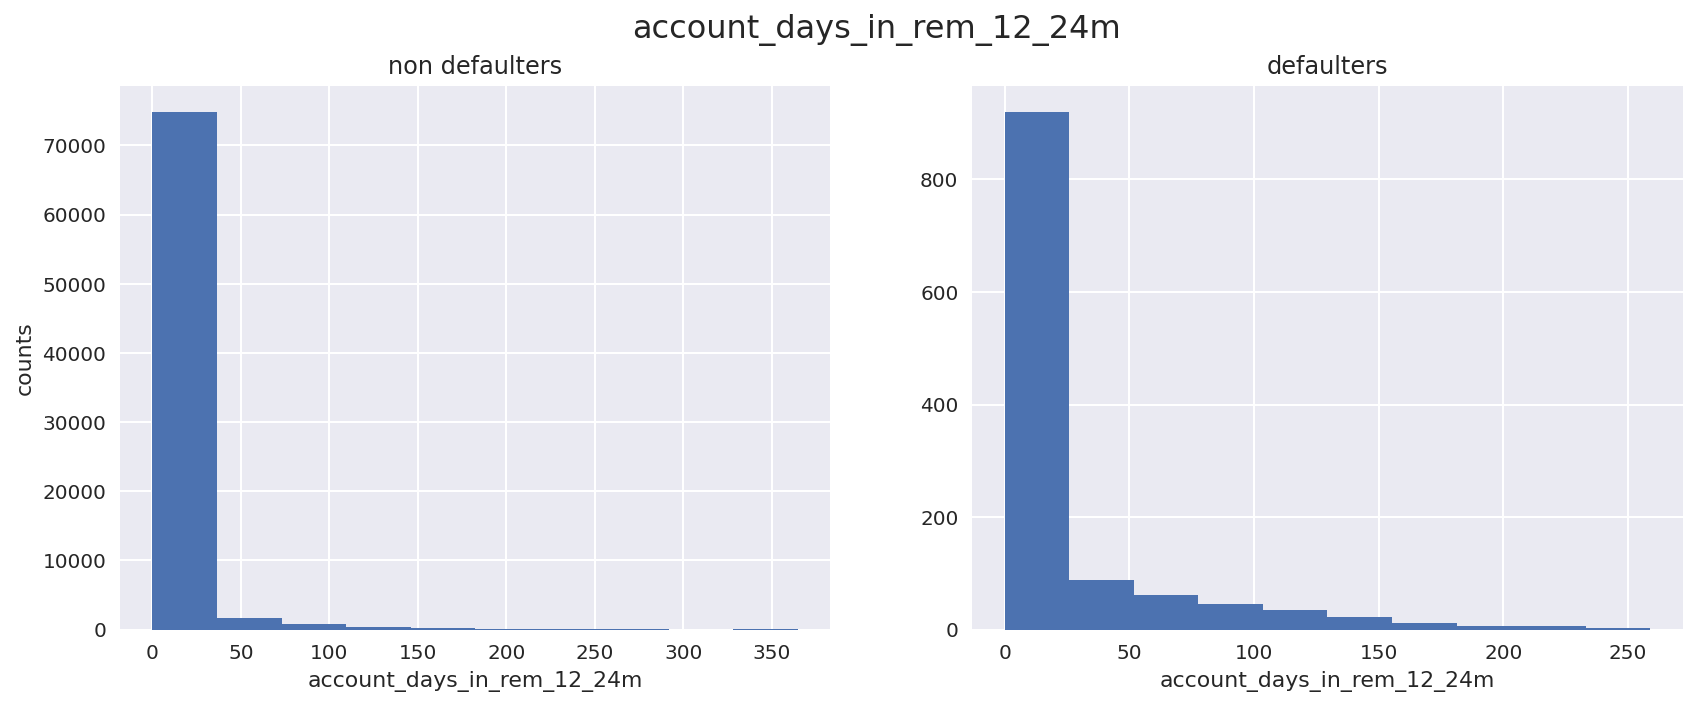

In [84]:
feature = 'account_days_in_rem_12_24m'
print('Defaulters tend to have larger account_days_in_rem')

defaulter_vs_non_defaulters(feature)

In [85]:
df.loc[df['account_days_in_rem_12_24m'].dropna().index].corr()['account_days_in_rem_12_24m'].sort_values(ascending=False).head(5)

account_days_in_rem_12_24m     1.000000
account_worst_status_12_24m    0.607126
account_worst_status_6_12m     0.390255
account_days_in_term_12_24m    0.352836
account_worst_status_3_6m      0.275448
Name: account_days_in_rem_12_24m, dtype: float64

In [86]:
# account_worst_status_12_24m & account_worst_status_12_24m without nan
no_nan = df.loc[df.loc[df['account_worst_status_12_24m'].dropna().index]['account_days_in_rem_12_24m'].dropna().index]

account_worst_status = 1 (the majority) have 0 account_days_in_rem. The worst_status increases with account_days_in_rem. We will use that to fill missing values.


<AxesSubplot:xlabel='account_worst_status_12_24m', ylabel='account_days_in_rem_12_24m'>

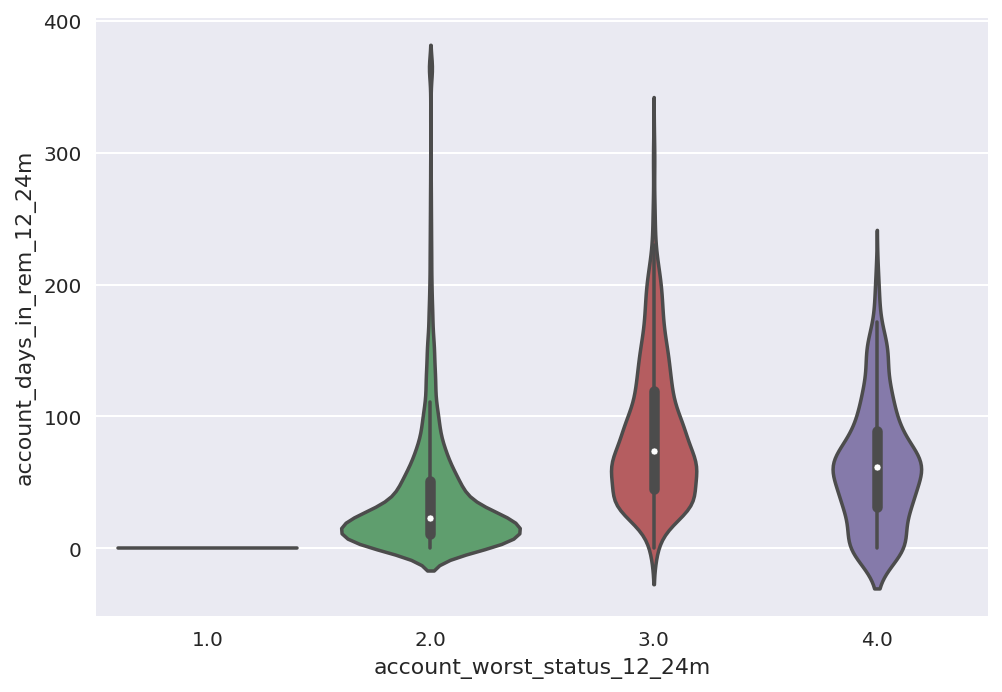

In [87]:
print('account_worst_status = 1 (the majority) have 0 account_days_in_rem. The worst_status increases with account_days_in_rem. We will use that to fill missing values.')
sns.violinplot(x='account_worst_status_12_24m',y='account_days_in_rem_12_24m',data=no_nan)

#### In notebook (1), this correlation is used to fit a linear model to fill the nan

## 13) num_active_div_by_paid_inv_0_12m

In [90]:
df.loc[df['num_active_div_by_paid_inv_0_12m'].dropna().index].corr()['num_active_div_by_paid_inv_0_12m'].sort_values(ascending=False).head(8)

num_active_div_by_paid_inv_0_12m    1.000000
num_active_inv                      0.298088
default                             0.137428
num_unpaid_bills                    0.118807
account_worst_status_12_24m         0.115073
account_worst_status_6_12m          0.113525
avg_payment_span_0_12m              0.111819
account_worst_status_3_6m           0.095144
Name: num_active_div_by_paid_inv_0_12m, dtype: float64

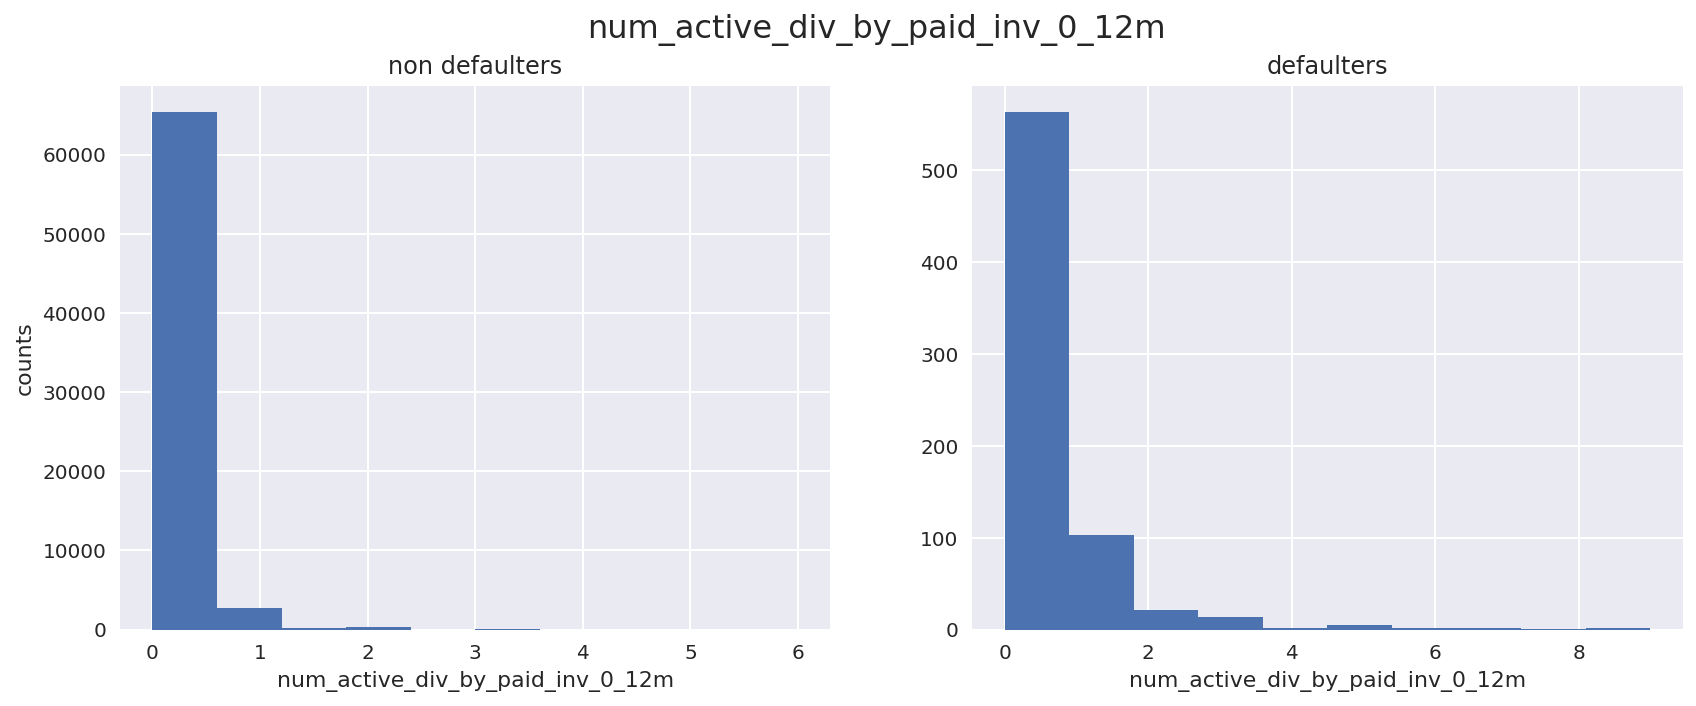

In [91]:
defaulter_vs_non_defaulters('num_active_div_by_paid_inv_0_12m')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='num_active_inv', ylabel='num_active_div_by_paid_inv_0_12m'>

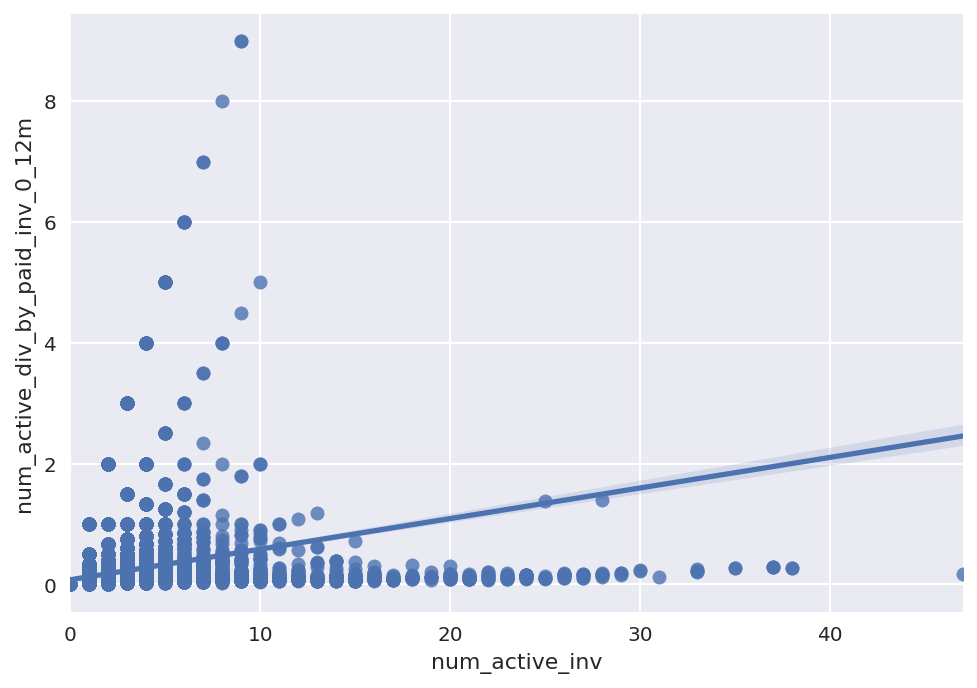

In [92]:
sns.regplot('num_active_inv','num_active_div_by_paid_inv_0_12m',data=df)

#### Since there is not a simple linear strategy, the nan are filled in using a KNN strategy in notebook (1).
#### More time consuming, but preciser.